# Run AOS on real images

In [84]:
from pathlib import Path

import matplotlib.pyplot as plt
from flow_analysis_comps.processing.Fourier.OrientationSpaceManager import (
    orientationSpaceManager,
)
import colorcet  # noqa: F401
from flow_analysis_comps.data_structs.AOS_structs import OSFilterParams
from flow_analysis_comps.data_structs.kymographs import (
    graphExtractConfig,
    kymoExtractConfig,
)
from flow_analysis_comps.processing.graph_extraction.graph_extract import (
    VideoGraphExtractor,
)
from flow_analysis_comps.processing.kymographing.kymographer import KymographExtractor
import colorcet as cc

%matplotlib widget

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from flow_analysis_comps.data_structs.AOS_structs import angle_filter_values


video_root_folder = Path(
    r"\\tsu-exp002\Data\Video\20250711_080235_SCP2505A065"
    # r"G:\AMOLF_Data\AMOLF-SHIMIZU Dropbox\Simon van Staalduine\033"
)
graph_data = VideoGraphExtractor(video_root_folder, graphExtractConfig()).edge_data
kymograph_list = KymographExtractor(
    graph_data, kymoExtractConfig()
).processed_kymographs

AOS_params = OSFilterParams(
    space_frequency_center=0.15,
    # space_frequency_width=0.3,
    orientation_accuracy=24.0,
    x_spacing=kymograph_list[0].deltas.delta_x,
    y_spacing=kymograph_list[0].deltas.delta_t,
    padding=50,
    multires_filter_params=angle_filter_values(
        magnitude=.01,
        first_derivative=.1,
        second_derivative=7.0
)
)
AOS_manager = orientationSpaceManager(AOS_params, kymograph_list[0].kymo_no_static)

angles_dict = AOS_manager.get_all_angles()

[2025-08-07 15:44:15] INFO flow_analysis_comps.kymographer: Extracted edge coordinates from \\tsu-exp002\Data\Video\20250711_080235_SCP2505A065


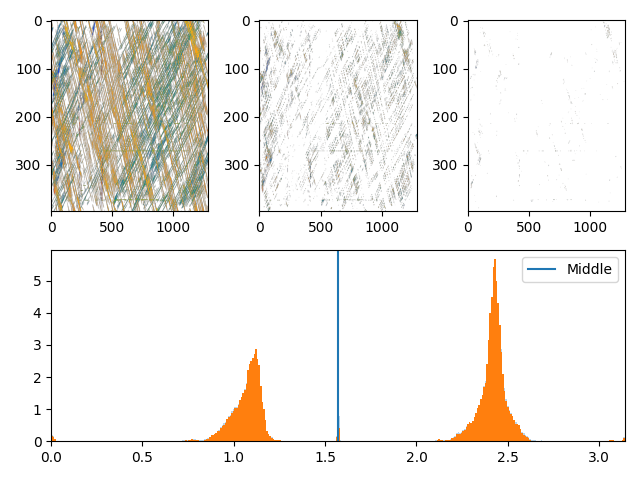

In [86]:
import numpy as np
unpad = 50

angles_im = angles_dict["maxima"]
angles_im_trunc = angles_im[:, unpad:-unpad, unpad:-unpad]
values_im = angles_dict["values_max"]

fig, ax = plt.subplot_mosaic([["Ori1", "Ori2", "Ori3"], ["Histo", "Histo","Histo",]])
    
for i, im in enumerate(angles_im[:3]):
    ax[f"Ori{i+1}"].imshow(im.real, cmap=cc.cm.rainbow4, vmin=0, vmax=np.pi, aspect='auto')

ax["Histo"].hist(angles_im[~np.isnan(angles_im)], bins=360, density=True, alpha=0.3)
ax["Histo"].hist(angles_im_trunc[~np.isnan(angles_im_trunc)], bins=360, density=True)
ax["Histo"].axvline(np.pi / 2, label="Middle")
ax["Histo"].set_xlim(0, np.pi)
# for angle in multi_line_angles:
#     angle_adj = (angle + 90) % 180
#     ax["Histo"].axvline(np.deg2rad(angle_adj), label=rf"$\theta={angle_adj}$", alpha=.2)
ax["Histo"].legend()
fig.tight_layout()

# Test with test data

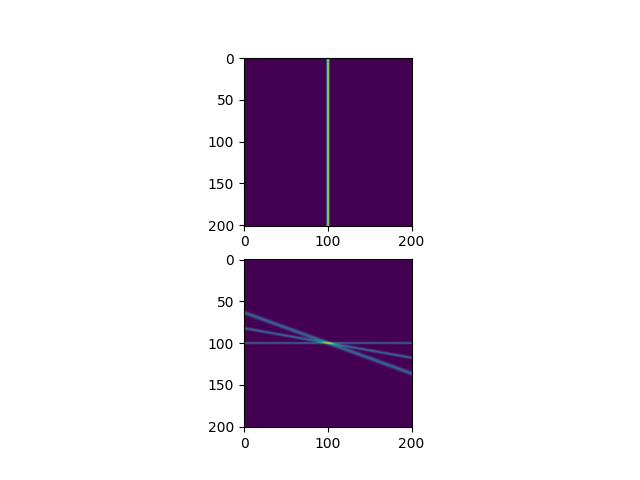

In [44]:
from flow_analysis_comps.test_data import single_line_img, crossing_line_img
from flow_analysis_comps.util.image_manips import mirror_pad_with_exponential_fade
import numpy as np
import skimage

single_line_angle = 90
multi_line_angles = np.array([0, 10,20])
imsize = 201

test_single = single_line_img(single_line_angle, std_dev=1, img_size=(imsize, imsize))
test_crossing = crossing_line_img(
    multi_line_angles, [0.8, 1, 1.4], img_size=(imsize, imsize)
)

# test_single = skimage.util.random_noise(test_single, mode="gaussian", var=0.01)
# test_crossing = skimage.util.random_noise(test_crossing, mode="gaussian", var=0.1)

# test_single = mirror_pad_with_exponential_fade(test_single, pad)
# test_crossing = mirror_pad_with_exponential_fade(test_crossing, pad)

fig, ax = plt.subplots(2)
ax[0].imshow(test_single)
ax[1].imshow(test_crossing)

In [ ]:
from flow_analysis_comps.data_structs.AOS_structs import angle_filter_values


AOS_params = OSFilterParams(
    space_frequency_center=0.15,
    # space_frequency_width=0.3,
    orientation_accuracy=24,
    x_spacing=1,
    y_spacing=1,
    padding=30,
    multires_filter_params=angle_filter_values(
        magnitude=.01,
        first_derivative=.1,
        second_derivative=7.0
)
)

print(AOS_params.nr_of_samples)
AOS_manager = orientationSpaceManager(AOS_params, test_crossing)

filter_arrays = AOS_manager.filter_arrays
print(filter_arrays.shape)


angles_dict = AOS_manager.get_max_angles()
nlms_mask = AOS_manager.nlms_simple_case()

49
(261, 261, 49)


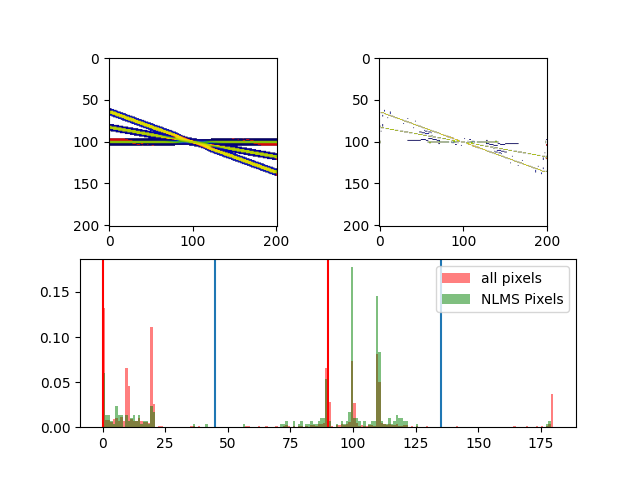

In [55]:
from flow_analysis_comps.visualizing.AOSFilterVisualizer import AOSVisualizer
import numpy as np

full_orientation = np.rad2deg(angles_dict)
nlms_orientation = np.where(nlms_mask, np.rad2deg(angles_dict), np.nan)
# angles_max_max = np.nanmax(angles_dict["angles_maxima"].real, axis=0)
# print(angles_dict.keys())

fig, ax = plt.subplot_mosaic(
    [["Orientation", "NLMS_orientation"], ["Histograms", "Histograms"]]
)
ax["Orientation"].imshow(full_orientation, cmap=cc.cm.rainbow4, vmin=0, vmax=180)
ax["NLMS_orientation"].imshow(nlms_orientation, cmap=cc.cm.rainbow4, vmin=0, vmax=180)
ax["Histograms"].hist(
    full_orientation.flatten(),
    bins=180,
    range=(0, 180),
    density=True,
    alpha=0.5,
    label="all pixels",
    color="red",
)
ax["Histograms"].hist(
    nlms_orientation.flatten(),
    bins=180,
    range=(0, 180),
    density=True,
    alpha=0.5,
    label="NLMS Pixels",
    color="green",
)
ax["Histograms"].axvline(45)
ax["Histograms"].axvline(135)
ax["Histograms"].axvline(single_line_angle, c="red")
ax["Histograms"].axvline((single_line_angle + 90) % 180, c="red")
ax["Histograms"].legend()


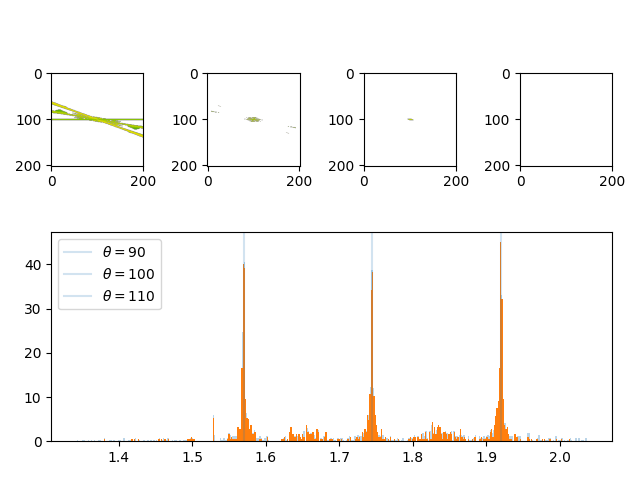

In [56]:
output_dict = AOS_manager.get_all_angles()

unpad = 20

angles_im = output_dict["maxima"]
angles_im_trunc = angles_im[:, unpad:-unpad, unpad:-unpad]
values_im = output_dict["values_max"]

fig, ax = plt.subplot_mosaic([["Ori1", "Ori2", "Ori3", "Ori4"], ["Histo", "Histo","Histo","Histo",]])
    
for i, im in enumerate(angles_im[:4]):
    ax[f"Ori{i+1}"].imshow(im.real, cmap=cc.cm.rainbow4, vmin=0, vmax=np.pi)
ax["Histo"].hist(angles_im[~np.isnan(angles_im)], bins=360, density=True, alpha=0.3)
ax["Histo"].hist(angles_im_trunc[~np.isnan(angles_im_trunc)], bins=360, density=True)
for angle in multi_line_angles:
    angle_adj = (angle + 90) % 180
    ax["Histo"].axvline(np.deg2rad(angle_adj), label=rf"$\theta={angle_adj}$", alpha=.2)
ax["Histo"].legend()
fig.tight_layout()
    